In [1]:
import json
import math
import random
import time
from io import BytesIO
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
from locus.data.QuadTree import calc_enclosing_cell
from locus.utils.paths import PROCESSED_DATA_DIR
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2


In [2]:
shards_dir = PROCESSED_DATA_DIR / "LDoGI/shards"
shards_dir

PosixPath('/home/dkenez/Projects/Locus/locus-model/data/processed/LDoGI/shards')

In [4]:
# Create a DataFrame with a column called index and data fill with 15 records
df1 = pl.LazyFrame(
    {
        "index": range(15),
        "data": range(15),
    }
)

In [5]:
df1.collect()

index,data
i64,i64
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8


In [6]:
# Create a new DataFrame with a column called index fill with 4 records with random non conflicting values between 0-15
df2 = pl.LazyFrame(
    {
        "excluded_id": [2, 11, 13],
    }
)

In [7]:
df2.collect()

excluded_id
i64
2
11
13


In [8]:
batch_size = 3
# create list with 0-14 and shuffle it
indices = list(range(df1.collect().shape[0] - df2.collect().shape[0]))
random.shuffle(indices)
indices

[8, 6, 9, 2, 7, 5, 0, 4, 10, 3, 11, 1]

In [9]:
def sanitise_indices(indices, val_len, df2):
    ret_array = []
    # check if the index is in the second dataframe
    for i, idx in enumerate(indices):
        # get the row number of the index in df2

        is_sanitised = False
        ret_idx = idx
        while not is_sanitised:
            matches = df2.with_row_index(offset=0).filter(pl.col("excluded_id") == ret_idx).collect()
            if matches.shape[0] > 0:
                ret_idx = val_len + matches["index"][0]
            else:
                is_sanitised = True
                ret_array.append(ret_idx)
    return ret_array

In [10]:
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
sanitise_indices(indices, df1.collect().shape[0] - df2.collect().shape[0], df2)

[0, 1, 12, 3, 4, 5, 6, 7, 8, 9, 10, 14]

In [11]:
# generator that yields the indices in batches
def batch_indices(batch_size, indices):
    for i in range(0, len(indices), batch_size):
        ret_indices = indices[i : i + batch_size]
        ret_indices = sanitise_indices(ret_indices, df1.collect().shape[0] - df2.collect().shape[0], df2)
        yield ret_indices

In [12]:
indices = list(range(df1.collect().shape[0] - df2.collect().shape[0]))
for batch in batch_indices(batch_size, indices):
    print(batch)

[0, 1, 12]
[3, 4, 5]
[6, 7, 8]
[9, 10, 14]


## Shuffling a dataset out of memory


In [13]:
# source: https://stackoverflow.com/a/53551417
# license: https://creativecommons.org/licenses/by-sa/4.0/

# Return a randomized "range" using a Linear Congruential Generator
# to produce the number sequence. Parameters are the same as for
# python builtin "range".
#   Memory  -- storage for 8 integers, regardless of parameters.
#   Compute -- at most 2*"maximum" steps required to generate sequence.
#
def random_range(start, stop=None, step=None):
    # Set a default values the same way "range" does.
    if stop is None:
        start, stop = 0, start
    if step is None:
        step = 1

    # Use a mapping to convert a standard range into the desired range.
    def mapping(i):
        return i * step + start

    # Compute the number of numbers in this range.
    maximum = (stop - start) // step
    # Seed range with a random integer.
    value = random.randint(0, maximum)
    #
    # Construct an offset, multiplier, and modulus for a linear
    # congruential generator. These generators are cyclic and
    # non-repeating when they maintain the properties:
    #
    #   1) "modulus" and "offset" are relatively prime.
    #   2) ["multiplier" - 1] is divisible by all prime factors of "modulus".
    #   3) ["multiplier" - 1] is divisible by 4 if "modulus" is divisible by 4.
    #
    offset = random.randint(0, maximum) * 2 + 1  # Pick a random odd-valued offset.
    multiplier = 4 * (maximum // 4) + 1  # Pick a multiplier 1 greater than a multiple of 4.
    modulus = int(
        2 ** math.ceil(math.log2(maximum))
    )  # Pick a modulus just big enough to generate all numbers (power of 2).
    # Track how many random numbers have been returned.
    found = 0
    while found < maximum:
        # If this is a valid value, yield it in generator fashion.
        if value < maximum:
            found += 1
            yield mapping(value)
        # Calculate the next value in the sequence.
        value = (value * multiplier + offset) % modulus

In [14]:
import networkx as nx
from locus.data.QuadTree import CellState

G = nx.read_gml(PROCESSED_DATA_DIR / "LDoGI/quadtrees/qt.gml")
active_cells = [node for node in list(G.nodes) if G.nodes[node]["state"] == CellState.ACTIVE.value]

In [55]:
class LDoGIDataset(Dataset):
    data: pl.DataFrame

    def __init__(self, data_path: str | Path, shards: Iterable[str], active_cells):
        # Specify the file path
        data_path = Path(data_path)

        self.load_data(data_path, shards)

        self.active_cells = active_cells
        self.transforms = v2.Compose(
            [
                v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
                v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
                # ...
                v2.RandomResizedCrop(size=(360, 360), antialias=True),  # Or Resize(antialias=True)
                # ...
                # v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
                # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

    def load_data(self, data_path: Path, shards: Iterable[str]):
        desc_path = data_path / "describe.json"
        shards_dir = data_path / "shards"

        # Read the JSON file
        with open(desc_path, "r") as file:
            data_description = json.load(file)

        description_data = {"path": [], "count": [], "min_index": [], "max_index": [], "shard": []}
        for file in data_description["files"]:
            if file["name"] not in shards:
                continue

            shard_path = shards_dir / f'{file["name"]}.parquet'
            if not shard_path.exists():
                continue

            description_data["path"].append(shard_path)
            description_data["count"].append(file["count"])
            description_data["min_index"].append(file["min_index"])
            description_data["max_index"].append(file["max_index"])
            description_data["shard"].append(pl.scan_parquet(shard_path))

        self.data = pl.DataFrame(
            description_data,
            schema={
                "path": pl.Object,
                "count": pl.Int64,
                "min_index": pl.Int64,
                "max_index": pl.Int64,
                "shard": pl.Object,
            },
        )

        self.data = self.data.sort("min_index").set_sorted(["min_index", "max_index"]).with_row_index("shard_index")

    def relevant_shards(self, idx_df: pl.DataFrame):
        return (
            idx_df
            # add necessary columns, sort and set flag
            .sort("idx")
            .set_sorted("idx")
            # join with data
            .join_asof(self.data, left_on="idx", right_on="min_index", strategy="backward")
            # clean up
            .sort("index")
            .drop("index")
            # group by shard index and aggregate
            .group_by(["shard_index"])
            .agg(pl.col("idx"))
            .join(self.data, on="shard_index")
        )

    def __len__(self):
        return self.data.select(pl.len()).collect()["len"][0]

    def __getitem__(self, idx):
        def extract_row_data(row: tuple[int, float, float, bytes]):
            idx = row["id"]

            lat = row["latitude"]
            lon = row["longitude"]
            label = calc_enclosing_cell(lat, lon, self.active_cells)

            im_io = BytesIO(row["image"])
            im_pil = Image.open(im_io)
            im = self.transforms(im_pil)

            return idx, im, label

        # if idx is a list of indices
        if not isinstance(idx, Iterable):
            idx = [idx]

        idx_df = pl.DataFrame({"idx": idx}, schema={"idx": pl.Int64}).with_row_index()

        relevant_shards = self.relevant_shards(idx_df)

        ids = []
        ims = []
        labels = []

        for row in relevant_shards.iter_rows(named=True):
            data_rows = row["shard"].filter(pl.col("id").is_in(row["idx"])).collect()

            for data_row in data_rows.iter_rows(named=True):
                id_row, im, label = extract_row_data(data_row)
                ids.append(id_row)
                ims.append(im)
                labels.append(label)

        read_data_df = pl.DataFrame(
            {
                "id": ids,
                "image": ims,
                "label": labels,
            },
            schema={"id": pl.Int64, "image": pl.Object, "label": pl.String},
        )
        sorted_df = idx_df.join(read_data_df, left_on="idx", right_on="id", how="left").sort("idx")

        ims = torch.stack(ims)
        return ims, labels

In [56]:
data_dir = PROCESSED_DATA_DIR / "LDoGI"
ds = LDoGIDataset(data_dir, [f"shard_{i}" for i in range(142)], active_cells)

In [57]:
b = ds[[random.randint(0, 3993899) for _ in range(4)]]

In [21]:
ds.relevant_shards([random.randint(0, 50000) for _ in range(1000)]).head(3)

shard_index,idx,path,count,min_index,max_index,shard
u32,list[i64],object,i64,i64,i64,object
0,"[25752, 9638, … 11617]",/home/dkenez/Projects/Locus/locus-model/data/processed/LDoGI/shards/shard_0.parquet,29999,0,29998,naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan) Parquet SCAN /home/dkenez/Projects/Locus/locus-model/data/processed/LDoGI/shards/shard_0.parquet PROJECT */4 COLUMNS
1,"[47983, 49425, … 30708]",/home/dkenez/Projects/Locus/locus-model/data/processed/LDoGI/shards/shard_1.parquet,30000,29999,59998,naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan) Parquet SCAN /home/dkenez/Projects/Locus/locus-model/data/processed/LDoGI/shards/shard_1.parquet PROJECT */4 COLUMNS


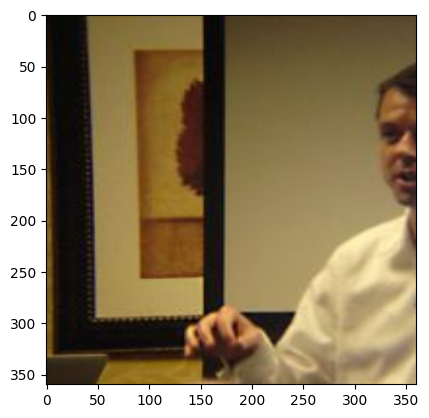

In [23]:
plt.imshow(ds[120, 142, 145][0][0].permute(1, 2, 0))
plt.show()

In [24]:
np.log10(5001)

3.699056854547668

In [28]:
# function that times the execution of a function
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        ret = func(*args, **kwargs)
        print(f"{func.__name__} took {time.time() - start:.2f} seconds to fetch {args[0]} items")
        return ret, time.time() - start

    return wrapper

In [29]:
# timeit example
@timeit
def get_item_timer(n: int):
    ds[[random.randint(0, 3993899) for _ in range(n)]]

get_item_timer(3)

get_item_timer took 2.14 seconds to fetch 3 items


(None, 2.142548084259033)

In [30]:
def write_as_json(X, Y, Y_mean, Y_std, Y_avg_time):
    # stats into json file
    with open("results.json", "w") as file:
        json.dump(
            {
                "X": X.tolist(),
                "Y": Y,
                "Y_mean": Y_mean,
                "Y_std": Y_std,
                "Y_avg_time": Y_avg_time,
            },
            file,
        )

In [31]:
# x should be a logarithmix linspace from 1 to 5000
X = np.logspace(0, np.log10(2000.5), 20, dtype=np.int64)
# X = np.logspace(0, 0.8, 3, dtype=np.int64)

# x remove duplicates
X = np.unique(X)

Y = []
Y_mean = []
Y_std = []
Y_avg_time = []
for x in X:
    y = []
    for i in range(5):
        _, t = get_item_timer(x)
        y.append(t)

    Y.append(y)
    Y_mean.append(np.mean(y))
    Y_std.append(np.std(y))
    Y_avg_time.append(np.mean(y) / x)

    write_as_json(X, Y, Y_mean, Y_std, Y_avg_time)

get_item_timer took 0.79 seconds to fetch 1 items
get_item_timer took 0.79 seconds to fetch 1 items
get_item_timer took 0.54 seconds to fetch 1 items
get_item_timer took 0.75 seconds to fetch 1 items
get_item_timer took 0.75 seconds to fetch 1 items
get_item_timer took 1.54 seconds to fetch 2 items
get_item_timer took 1.31 seconds to fetch 2 items
get_item_timer took 1.53 seconds to fetch 2 items
get_item_timer took 1.64 seconds to fetch 2 items
get_item_timer took 1.56 seconds to fetch 2 items
get_item_timer took 1.86 seconds to fetch 3 items
get_item_timer took 2.59 seconds to fetch 3 items
get_item_timer took 2.37 seconds to fetch 3 items
get_item_timer took 2.49 seconds to fetch 3 items
get_item_timer took 2.40 seconds to fetch 3 items
get_item_timer took 2.97 seconds to fetch 4 items
get_item_timer took 3.28 seconds to fetch 4 items
get_item_timer took 3.15 seconds to fetch 4 items
get_item_timer took 3.14 seconds to fetch 4 items
get_item_timer took 3.07 seconds to fetch 4 items


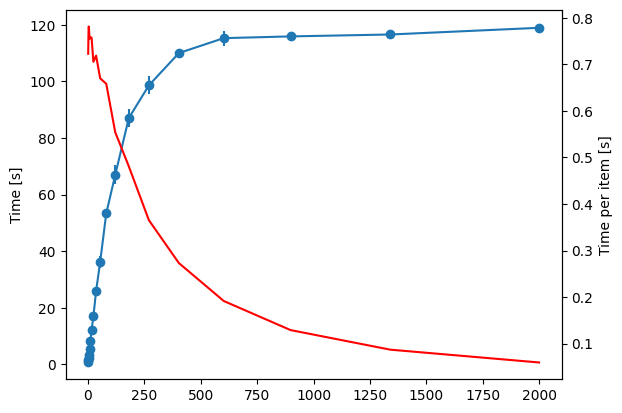

In [32]:
fig, ax1 = plt.subplots()

# Plot error bar on first axis
ax1.errorbar(X, Y_mean, Y_std, fmt='-o')
ax1.set_ylabel('Time [s]')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")

# Create second axis
ax2 = ax1.twinx()

# Plot line chart on second axis
ax2.plot(X, Y_avg_time, color='r')
ax2.set_ylabel('Time per item [s]')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

In [45]:
N = [random.randint(0, 3993899) for _ in range(10)]
N

[698370,
 3131292,
 2636948,
 250353,
 1530566,
 3969572,
 3112827,
 510012,
 463626,
 3855639]

In [48]:
A = ds[N]
A[1]

['1021203',
 '1022303312300',
 '03001011',
 '021112132',
 '10221203120201',
 '0311132103323',
 '1022101',
 '121222',
 '030013013',
 '102232120']

In [51]:
A = ds[N[0]]
A[1][0]

KeyboardInterrupt: 